In [ ]:
pip install pandas matplotlib seaborn tabulate


In [ ]:
# prompt: upload folder not just one file

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

KeyboardInterrupt: 

In [ ]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

sns.set(style="whitegrid")
SUMMARY_DIR = "results-finetuned"
OUTPUT_DIR = "plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def parse_survey_file(filepath, model_name):
    data = []
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            if line.startswith("Group:"):
                match = re.match(r"Group:\s(.+),\sN:\s(\d+),\sBias:\s([\d.]+),\sSoft:\s([\d.]+)", line)
                if match:
                    group, n, bias, soft = match.groups()
                    data.append({
                        "Model": model_name,
                        "Group": group.strip(),
                        "N": int(n),
                        "Bias": float(bias),
                        "Soft": float(soft),
                        "Type": "Survey"
                    })
    return data

def parse_winoqueer_file(filepath, model_name):
    data = []
    with open(filepath, "r", encoding="utf-8") as f:
        current_category = None
        current_n = None
        current_bias = None
        current_soft = None
        for line in f:
            line = line.strip()
            if line.startswith("Category:"):
                current_category = line.split(":")[1].strip()
            elif "Number of examples:" in line:
                current_n = int(line.split(":")[1].strip())
            elif "Bias score against group" in line:
                current_bias = float(line.split(":")[1].strip())
            elif "Mean soft score" in line:
                current_soft = float(line.split(":")[1].strip())
                if current_category and current_n is not None:
                    data.append({
                        "Model": model_name,
                        "Group": current_category,
                        "N": current_n,
                        "Bias": current_bias,
                        "Soft": current_soft,
                        "Type": "WinoQueer"
                    })
    return data

def extract_model_name(filename):
    name = filename.replace("results:", "").replace("results_", "").replace(".csv.summary", "")
    if name.endswith("_survey"):
        return name[:-7]  # remove '_survey'
    return name

def plot_bias_soft(df, model_name, plot_type, n_threshold=5):
    df = df[df["N"] >= n_threshold]
    if df.empty:
        return

    df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)
    df = df.sort_values(by="Bias", ascending=False)

    df_melted = df.melt(id_vars=["Model", "GroupLabel"], value_vars=["Bias", "Soft"],
                        var_name="ScoreType", value_name="Score")

    plt.figure(figsize=(12, max(6, len(df) * 0.4)))
    ax = sns.barplot(data=df_melted, y="GroupLabel", x="Score", hue="ScoreType", orient="h")
    ax.set_title(f"{model_name} – {plot_type} Bias and Soft Scores", fontsize=14)
    ax.set_xlabel("Score")
    ax.set_ylabel("Group")

    plt.tight_layout()
    plot_path = os.path.join(OUTPUT_DIR, f"{model_name}_{plot_type.lower()}_bias_plot.png")
    plt.savefig(plot_path, dpi=300)
    plt.close()
    print(f"✅ Saved: {plot_path}")

def plot_comparison(df_all, plot_type, n_threshold=5):
    df_all = df_all[df_all["N"] >= n_threshold]
    if df_all.empty:
        print(f"⚠️ No data above threshold N={n_threshold} for {plot_type} comparison.")
        return

    models_in_plot = df_all["Model"].unique()
    print(f"📊 Models in {plot_type} comparison: {list(models_in_plot)}")

    for score_type in ["Bias", "Soft"]:
        df_pivot = df_all.pivot_table(index="Group", columns="Model", values=score_type)
        df_pivot = df_pivot.dropna(how='all')

        if df_pivot.empty:
            continue

        df_pivot.plot(kind='barh', figsize=(14, max(6, len(df_pivot) * 0.4)))
        plt.title(f"{plot_type} – {score_type} Score by Group Across Models", fontsize=14)
        plt.xlabel("Score")
        plt.ylabel("Group")
        plt.tight_layout()

        path = os.path.join(OUTPUT_DIR, f"comparison_{plot_type.lower()}_{score_type.lower()}.png")
        plt.savefig(path, dpi=300)
        plt.close()
        print(f"✅ Saved: {path}")

def main():
    survey_data = {}
    wino_data = {}

    summary_files = [f for f in os.listdir(SUMMARY_DIR) if f.endswith(".summary")]
    print(f"📁 Found {len(summary_files)} .summary files")
    print("📄 Filenames:", summary_files)

    for file in summary_files:
        filepath = os.path.join(SUMMARY_DIR, file)
        model_name = extract_model_name(file)

        if "survey" in file.lower():
            survey_data.setdefault(model_name, []).extend(parse_survey_file(filepath, model_name))
        else:
            wino_data.setdefault(model_name, []).extend(parse_winoqueer_file(filepath, model_name))

    # Log final model summary
    all_models = set(survey_data.keys()).union(set(wino_data.keys()))
    print("\n🧠 Final model summary:")
    for model in sorted(all_models):
        print(f"- {model}: Survey={'✅' if model in survey_data else '❌'}, WinoQueer={'✅' if model in wino_data else '❌'}")

    all_survey_rows = []
    all_wino_rows = []

    for model_name, data in survey_data.items():
        df = pd.DataFrame(data)
        if not df.empty:
            all_survey_rows.append(df)
            plot_bias_soft(df, model_name, "Survey")

    for model_name, data in wino_data.items():
        df = pd.DataFrame(data)
        if not df.empty:
            all_wino_rows.append(df)
            plot_bias_soft(df, model_name, "WinoQueer")

    if all_survey_rows:
        combined_survey = pd.concat(all_survey_rows, ignore_index=True)
        plot_comparison(combined_survey, "Survey")

    if all_wino_rows:
        combined_wino = pd.concat(all_wino_rows, ignore_index=True)
        plot_comparison(combined_wino, "WinoQueer")

if __name__ == "__main__":
    main()


📁 Found 15 .summary files
📄 Filenames: ['results_gpt2-finetuned_autoregressive.csv.summary', 'results_gpt2-finetuned_survey.csv.summary', 'results_opt-350m-finetuned_autoregressive.csv.summary', 'results_multi_bert-finetuned_survey.csv.summary', 'results_german_bert-finetuned_survey.csv.summary', 'results_xlm-mlm-ende-1024-finetuned_metric.csv.summary', 'results_xlm-clm-ende-1024-finetuned_autoregressive.csv.summary', 'results_xlm-roberta-base-finetuned_survey.csv.summary', 'results_xlm-clm-ende-1024-finetuned_survey.csv.summary', 'results_xlm-mlm-ende-1024-finetuned_survey.csv.summary', 'results_opt-350m-finetuned_survey.csv.summary', 'results_bloom-560m-finetuned_survey.csv.summary', 'results_german_bert-finetuned_metric.csv.summary', 'results_multi_bert-finetuned_metric.csv.summary', 'results_xlm-roberta-base-finetuned_metric.csv.summary']

🧠 Final model summary:
- bloom-560m-finetuned: Survey=✅, WinoQueer=❌
- german_bert-finetuned: Survey=✅, WinoQueer=❌
- german_bert-finetuned_metr

/tmp/ipython-input-4-3216582385.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/gpt2-finetuned_survey_bias_plot.png


/tmp/ipython-input-4-3216582385.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/multi_bert-finetuned_survey_bias_plot.png


/tmp/ipython-input-4-3216582385.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/german_bert-finetuned_survey_bias_plot.png


/tmp/ipython-input-4-3216582385.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/xlm-roberta-base-finetuned_survey_bias_plot.png


/tmp/ipython-input-4-3216582385.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/xlm-clm-ende-1024-finetuned_survey_bias_plot.png


/tmp/ipython-input-4-3216582385.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/xlm-mlm-ende-1024-finetuned_survey_bias_plot.png


/tmp/ipython-input-4-3216582385.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/opt-350m-finetuned_survey_bias_plot.png


/tmp/ipython-input-4-3216582385.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/bloom-560m-finetuned_survey_bias_plot.png
✅ Saved: plots/gpt2-finetuned_autoregressive_winoqueer_bias_plot.png
✅ Saved: plots/opt-350m-finetuned_autoregressive_winoqueer_bias_plot.png
✅ Saved: plots/xlm-mlm-ende-1024-finetuned_metric_winoqueer_bias_plot.png
✅ Saved: plots/xlm-clm-ende-1024-finetuned_autoregressive_winoqueer_bias_plot.png
✅ Saved: plots/german_bert-finetuned_metric_winoqueer_bias_plot.png
✅ Saved: plots/multi_bert-finetuned_metric_winoqueer_bias_plot.png
✅ Saved: plots/xlm-roberta-base-finetuned_metric_winoqueer_bias_plot.png
📊 Models in Survey comparison: ['gpt2-finetuned', 'multi_bert-finetuned', 'german_bert-finetuned', 'xlm-roberta-base-finetuned', 'xlm-clm-ende-1024-finetuned', 'xlm-mlm-ende-1024-finetuned', 'opt-350m-finetuned', 'bloom-560m-finetuned']
✅ Saved: plots/comparison_survey_bias.png
✅ Saved: plots/comparison_survey_soft.png
📊 Models in WinoQueer comparison: ['gpt2-finetuned_autoregressive', 'opt-350m-finetuned_autoregressive', 'xlm-mlm-en

/tmp/ipython-input-4-3216582385.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_wino = pd.concat(all_wino_rows, ignore_index=True)


✅ Saved: plots/comparison_winoqueer_bias.png
✅ Saved: plots/comparison_winoqueer_soft.png


In [ ]:
from google.colab import files
import shutil

# Replace 'plots' with the folder you want to download
shutil.make_archive("plots_download", 'zip', "plots")

files.download("plots_download.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tabulate import tabulate

sns.set(style="whitegrid")
SUMMARY_DIR = "result_summary"
OUTPUT_DIR = "plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)


def parse_survey_file(filepath, model_name):
    data = []
    overall_score = None
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            if "Overall Score:" in line:
                match = re.search(r"Overall Score:\s*([\d.]+)", line)
                if match:
                    overall_score = float(match.group(1))
            elif line.startswith("Group:"):
                match = re.match(r"Group:\s(.+),\sN:\s(\d+),\sBias:\s([\d.]+),\sSoft:\s([\d.]+)", line)
                if match:
                    group, n, bias, soft = match.groups()
                    data.append({
                        "Model": model_name,
                        "Group": group.strip(),
                        "N": int(n),
                        "Bias": float(bias),
                        "Soft": float(soft),
                        "Type": "Survey"
                    })
    return data, overall_score


def parse_winoqueer_file(filepath, model_name):
    data = []
    overall_score = None
    current_category = None
    current_n = None
    current_bias = None
    current_soft = None

    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if "Winoqueer Overall Score:" in line:
                match = re.search(r"Winoqueer Overall Score:\s*([\d.]+)", line)
                if match:
                    overall_score = float(match.group(1))
            elif line.startswith("Category:"):
                current_category = line.split(":", 1)[1].strip()
                current_n = current_bias = current_soft = None
            elif "Number of examples:" in line:
                match = re.search(r"Number of examples:\s*(\d+)", line)
                if match:
                    current_n = int(match.group(1))
            elif "Bias score" in line and "against group" in line:
                match = re.search(r"against group\s+(.+?):\s+([\d.]+)", line)
                if match:
                    _, bias = match.groups()
                    current_bias = float(bias)
            elif "Mean soft score for group" in line:
                match = re.search(r"group\s+(.+?):\s+([\d.]+)", line)
                if match:
                    _, soft = match.groups()
                    current_soft = float(soft)

                if all(v is not None for v in [current_category, current_n, current_bias, current_soft]):
                    data.append({
                        "Model": model_name,
                        "Group": current_category,
                        "N": current_n,
                        "Bias": current_bias,
                        "Soft": current_soft,
                        "Type": "WinoQueer"
                    })

    return data, overall_score


def extract_model_name(filename):
    name = filename.replace("results:", "").replace("results_", "").replace(".csv.summary", "")
    if name.endswith("_survey"):
        name = name[:-7]  # Remove '_survey'
    return name


def plot_bias_soft(df, model_name, plot_type, n_threshold=5):
    df = df[df["N"] >= n_threshold]
    if df.empty:
        return

    df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)
    df = df.sort_values(by="Bias", ascending=False)

    df_melted = df.melt(id_vars=["Model", "GroupLabel"], value_vars=["Bias", "Soft"],
                        var_name="ScoreType", value_name="Score")

    plt.figure(figsize=(12, max(6, len(df) * 0.4)))
    ax = sns.barplot(data=df_melted, y="GroupLabel", x="Score", hue="ScoreType", orient="h")
    ax.set_title(f"{model_name} – {plot_type} Bias and Soft Scores", fontsize=14)
    ax.set_xlabel("Score")
    ax.set_ylabel("Group")
    plt.tight_layout()
    plot_path = os.path.join(OUTPUT_DIR, f"{model_name}_{plot_type.lower()}_bias_plot.png")
    plt.savefig(plot_path, dpi=300)
    plt.close()
    print(f"✅ Saved: {plot_path}")


def plot_comparison_table(df_all, plot_type):
    df_pivot = df_all.pivot_table(index="Group", columns="Model", values="Bias")
    if df_pivot.empty:
        return

    plt.figure(figsize=(min(25, 2 + len(df_pivot.columns)), max(6, len(df_pivot) * 0.5)))
    plt.axis('off')

    table_data = [["Group"] + df_pivot.columns.tolist()]
    for idx, row in df_pivot.iterrows():
        table_data.append([idx] + [f"{val:.2f}" if pd.notna(val) else "" for val in row.values])

    table = plt.table(cellText=table_data, loc='center', cellLoc='center', colLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    plt.title(f"{plot_type} Bias Score Comparison Table", fontsize=14)
    plt.tight_layout()
    path = os.path.join(OUTPUT_DIR, f"comparison_{plot_type.lower()}_bias_table.png")
    plt.savefig(path, dpi=300)
    plt.close()
    print(f"✅ Saved table: {path}")


def plot_overall_scores(overall_scores, plot_type):
    if not overall_scores:
        return
    df = pd.DataFrame(overall_scores)
    df = df.sort_values(by="Overall", ascending=False)

    plt.figure(figsize=(10, max(5, len(df) * 0.5)))
    ax = sns.barplot(data=df, x="Overall", y="Model", palette="Blues_d")
    ax.set_title(f"{plot_type} Overall Scores", fontsize=14)
    ax.set_xlabel("Overall Score")
    ax.set_ylabel("Model")
    plt.tight_layout()
    path = os.path.join(OUTPUT_DIR, f"{plot_type.lower()}_overall_scores.png")
    plt.savefig(path, dpi=300)
    plt.close()
    print(f"✅ Saved overall score plot: {path}")


def main():
    survey_data = {}
    wino_data = {}
    survey_overall = []
    wino_overall = []

    for file in os.listdir(SUMMARY_DIR):
        if not file.endswith(".summary"):
            continue

        filepath = os.path.join(SUMMARY_DIR, file)
        model_name = extract_model_name(file)

        if "survey" in file.lower():
            data, overall = parse_survey_file(filepath, model_name)
            survey_data.setdefault(model_name, []).extend(data)
            if overall is not None:
                survey_overall.append({"Model": model_name, "Overall": overall})
        else:
            data, overall = parse_winoqueer_file(filepath, model_name)
            wino_data.setdefault(model_name, []).extend(data)
            if overall is not None:
                wino_overall.append({"Model": model_name, "Overall": overall})

    all_survey_rows = []
    all_wino_rows = []

    for model_name, data in survey_data.items():
        df = pd.DataFrame(data)
        if not df.empty:
            all_survey_rows.append(df)
            plot_bias_soft(df, model_name, "Survey")

    for model_name, data in wino_data.items():
        df = pd.DataFrame(data)
        if not df.empty:
            all_wino_rows.append(df)
            plot_bias_soft(df, model_name, "WinoQueer")

    if all_survey_rows:
        combined_survey = pd.concat(all_survey_rows, ignore_index=True)
        plot_comparison_table(combined_survey, "Survey")
        plot_overall_scores(survey_overall, "Survey")

    if all_wino_rows:
        combined_wino = pd.concat(all_wino_rows, ignore_index=True)
        plot_comparison_table(combined_wino, "WinoQueer")
        plot_overall_scores(wino_overall, "WinoQueer")


if __name__ == "__main__":
    main()


/tmp/ipython-input-11-1757714999.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/gpt2_survey_bias_plot.png


/tmp/ipython-input-11-1757714999.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/german_bert_survey_bias_plot.png


/tmp/ipython-input-11-1757714999.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/opt-350m_survey_bias_plot.png


/tmp/ipython-input-11-1757714999.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/xlm-clm-ende-1024_survey_bias_plot.png


/tmp/ipython-input-11-1757714999.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/xlm-mlm-ende-1024_survey_bias_plot.png


/tmp/ipython-input-11-1757714999.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/bloom-560m_survey_bias_plot.png


/tmp/ipython-input-11-1757714999.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/xlm-roberta-base_survey_bias_plot.png


/tmp/ipython-input-11-1757714999.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/multi_bert_survey_bias_plot.png
✅ Saved: plots/multi_bert_metric_winoqueer_bias_plot.png
✅ Saved: plots/gpt2_autoregressive_winoqueer_bias_plot.png
✅ Saved: plots/german_bert_metric_winoqueer_bias_plot.png
✅ Saved: plots/xlm-mlm-ende-1024_metric_winoqueer_bias_plot.png
✅ Saved: plots/xlm-clm-ende-1024_autoregressive_winoqueer_bias_plot.png
✅ Saved: plots/bloom-560m_autoregressive_winoqueer_bias_plot.png
✅ Saved: plots/xlm-roberta-base_metric_winoqueer_bias_plot.png
✅ Saved: plots/opt-350m_autoregressive_winoqueer_bias_plot.png
✅ Saved table: plots/comparison_survey_bias_table.png
✅ Saved table: plots/comparison_winoqueer_bias_table.png


/tmp/ipython-input-11-1757714999.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x="Overall", y="Model", palette="Blues_d")


✅ Saved overall score plot: plots/winoqueer_overall_scores.png


In [ ]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")
SUMMARY_DIR = "result_summary"
OUTPUT_DIR = "plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)


def parse_survey_file(filepath, model_name):
    data = []
    overall_score = None
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            if "Overall Stereo Score:" in line:
                match = re.search(r"Overall Stereo Score:\s*([\d.]+)", line)
                if match:
                    overall_score = float(match.group(1))
            elif line.startswith("Group:"):
                match = re.match(r"Group:\s(.+),\sN:\s(\d+),\sBias:\s([\d.]+),\sSoft:\s([\d.]+)", line)
                if match:
                    group, n, bias, soft = match.groups()
                    data.append({
                        "Model": model_name,
                        "Group": group.strip(),
                        "N": int(n),
                        "Bias": float(bias),
                        "Soft": float(soft),
                        "Type": "Survey"
                    })
    return data, overall_score


def parse_winoqueer_file(filepath, model_name):
    data = []
    overall_score = None
    with open(filepath, "r", encoding="utf-8") as f:
        current_category = None
        current_n = None
        current_bias = None
        current_soft = None
        for line in f:
            line = line.strip()
            if "Winoqueer Overall Score:" in line:
                match = re.search(r"Winoqueer Overall Score:\s*([\d.]+)", line)
                if match:
                    overall_score = float(match.group(1))
            elif line.startswith("Category:"):
                current_category = line.split(":")[1].strip()
            elif "Number of examples:" in line:
                current_n = int(line.split(":")[1].strip())
            elif "Bias score" in line:
                current_bias = float(line.split(":")[1].strip())
            elif "Mean soft score" in line:
                current_soft = float(line.split(":")[1].strip())
                if current_category and current_n is not None:
                    data.append({
                        "Model": model_name,
                        "Group": current_category,
                        "N": current_n,
                        "Bias": current_bias,
                        "Soft": current_soft,
                        "Type": "WinoQueer"
                    })
    return data, overall_score


def extract_model_name(filename):
    name = filename.replace("results:", "").replace("results_", "").replace(".csv.summary", "")
    return name.replace("_survey", "")


def plot_bias_soft(df, model_name, plot_type, n_threshold=5):
    df = df[df["N"] >= n_threshold]
    if df.empty:
        return

    df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)
    df = df.sort_values(by="Bias", ascending=False)

    df_melted = df.melt(id_vars=["Model", "GroupLabel"], value_vars=["Bias", "Soft"],
                        var_name="ScoreType", value_name="Score")

    plt.figure(figsize=(12, max(6, len(df) * 0.4)))
    ax = sns.barplot(data=df_melted, y="GroupLabel", x="Score", hue="ScoreType", orient="h")
    ax.set_title(f"{model_name} – {plot_type} Bias and Soft Scores", fontsize=14)
    ax.set_xlabel("Score")
    ax.set_ylabel("Group")

    plt.tight_layout()
    path = os.path.join(OUTPUT_DIR, f"{model_name}_{plot_type.lower()}_bias_plot.png")
    plt.savefig(path, dpi=300)
    plt.close()
    print(f"✅ Saved: {path}")


def plot_overall_scores(overall_scores, plot_type):
    df = pd.DataFrame(list(overall_scores.items()), columns=["Model", "Overall Score"])
    df = df.sort_values(by="Overall Score", ascending=False)

    plt.figure(figsize=(10, max(4, len(df) * 0.5)))
    sns.barplot(data=df, y="Model", x="Overall Score", palette="viridis")
    plt.title(f"{plot_type} – Overall Scores", fontsize=14)
    plt.tight_layout()
    path = os.path.join(OUTPUT_DIR, f"{plot_type.lower()}_overall_scores.png")
    plt.savefig(path, dpi=300)
    plt.close()
    print(f"✅ Saved: {path}")


def plot_comparison_table(df_all, plot_type):
    if df_all.empty:
        return

    pivot = df_all.pivot_table(index="Group", columns="Model", values="Bias", aggfunc="mean")
    pivot = pivot.round(2).fillna("")

    fig, ax = plt.subplots(figsize=(1 + 1.2 * pivot.shape[1], 0.6 * pivot.shape[0]))
    ax.axis("off")
    tbl = ax.table(cellText=pivot.values,
                   rowLabels=pivot.index,
                   colLabels=pivot.columns,
                   cellLoc='center',
                   loc='center')

    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 1.4)

    plt.title(f"{plot_type} – Bias Score Table", fontsize=14, pad=20)
    path = os.path.join(OUTPUT_DIR, f"{plot_type.lower()}_bias_table.png")
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Saved: {path}")


def main():
    survey_data, wino_data = {}, {}
    survey_scores, wino_scores = {}, {}

    for file in os.listdir(SUMMARY_DIR):
        if not file.endswith(".summary"):
            continue

        filepath = os.path.join(SUMMARY_DIR, file)
        model_name = extract_model_name(file)

        if "survey" in file.lower():
            parsed_data, overall = parse_survey_file(filepath, model_name)
            if parsed_data:
                survey_data.setdefault(model_name, []).extend(parsed_data)
                survey_scores[model_name] = overall
        else:
            parsed_data, overall = parse_winoqueer_file(filepath, model_name)
            if parsed_data:
                wino_data.setdefault(model_name, []).extend(parsed_data)
                wino_scores[model_name] = overall

    all_survey_rows = []
    all_wino_rows = []

    for model_name, data in survey_data.items():
        df = pd.DataFrame(data)
        if not df.empty:
            all_survey_rows.append(df)
            plot_bias_soft(df, model_name, "Survey")

    for model_name, data in wino_data.items():
        df = pd.DataFrame(data)
        if not df.empty:
            all_wino_rows.append(df)
            plot_bias_soft(df, model_name, "WinoQueer")

    if all_survey_rows:
        combined_survey = pd.concat(all_survey_rows, ignore_index=True)
        plot_comparison_table(combined_survey, "Survey")
        plot_overall_scores(survey_scores, "Survey")

    if all_wino_rows:
        combined_wino = pd.concat(all_wino_rows, ignore_index=True)
        plot_comparison_table(combined_wino, "WinoQueer")
        plot_overall_scores(wino_scores, "WinoQueer")


if __name__ == "__main__":
    main()


/tmp/ipython-input-13-2080731861.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/gpt2_survey_bias_plot.png


/tmp/ipython-input-13-2080731861.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/german_bert_survey_bias_plot.png


/tmp/ipython-input-13-2080731861.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/opt-350m_survey_bias_plot.png


/tmp/ipython-input-13-2080731861.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/xlm-clm-ende-1024_survey_bias_plot.png


/tmp/ipython-input-13-2080731861.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/xlm-mlm-ende-1024_survey_bias_plot.png


/tmp/ipython-input-13-2080731861.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/bloom-560m_survey_bias_plot.png


/tmp/ipython-input-13-2080731861.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/xlm-roberta-base_survey_bias_plot.png


/tmp/ipython-input-13-2080731861.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GroupLabel"] = df.apply(lambda row: f"{row['Group']} (N={row['N']})", axis=1)


✅ Saved: plots/multi_bert_survey_bias_plot.png
✅ Saved: plots/multi_bert_metric_winoqueer_bias_plot.png
✅ Saved: plots/gpt2_autoregressive_winoqueer_bias_plot.png
✅ Saved: plots/german_bert_metric_winoqueer_bias_plot.png
✅ Saved: plots/xlm-mlm-ende-1024_metric_winoqueer_bias_plot.png
✅ Saved: plots/xlm-clm-ende-1024_autoregressive_winoqueer_bias_plot.png
✅ Saved: plots/bloom-560m_autoregressive_winoqueer_bias_plot.png
✅ Saved: plots/xlm-roberta-base_metric_winoqueer_bias_plot.png
✅ Saved: plots/opt-350m_autoregressive_winoqueer_bias_plot.png
✅ Saved: plots/survey_bias_table.png


/tmp/ipython-input-13-2080731861.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y="Model", x="Overall Score", palette="viridis")


✅ Saved: plots/survey_overall_scores.png
✅ Saved: plots/winoqueer_bias_table.png


/tmp/ipython-input-13-2080731861.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y="Model", x="Overall Score", palette="viridis")


✅ Saved: plots/winoqueer_overall_scores.png


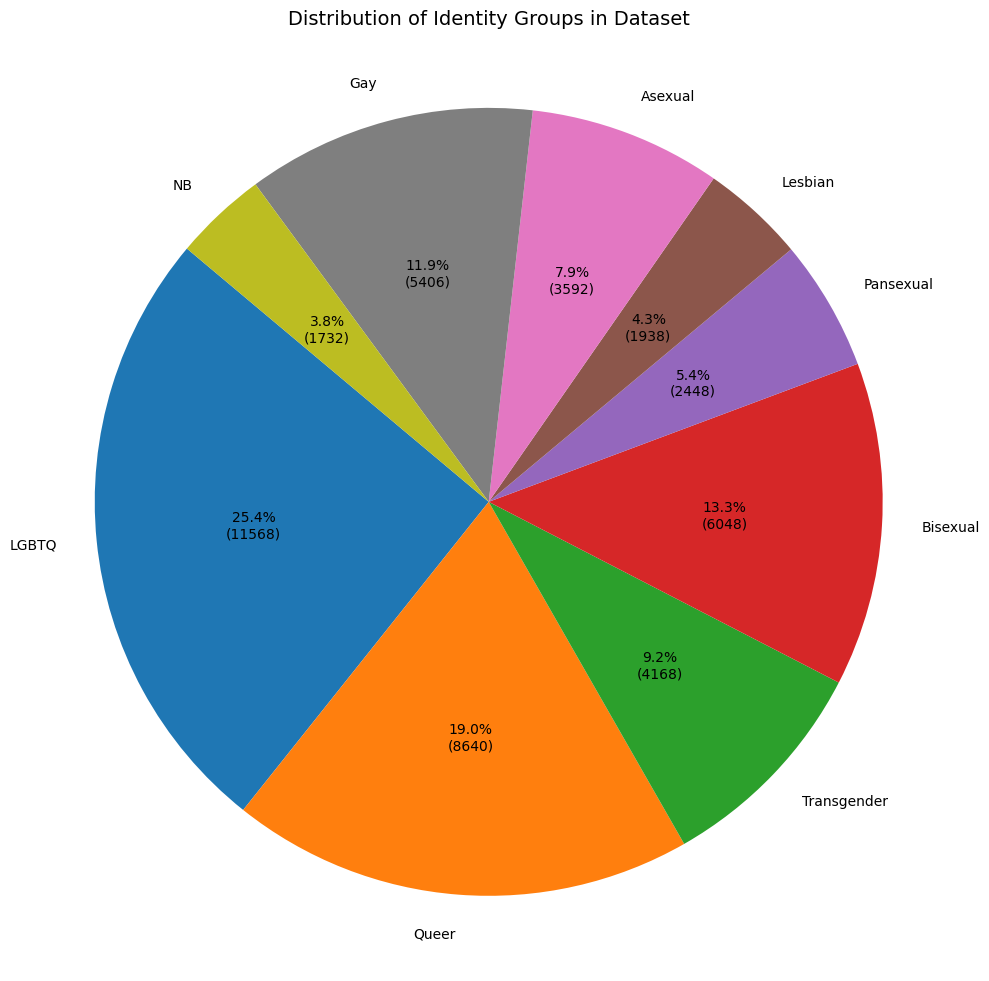

In [ ]:
import matplotlib.pyplot as plt

# Labels and values
group_labels = [
    "LGBTQ", "Queer", "Transgender", "Bisexual", "Pansexual",
    "Lesbian", "Asexual", "Gay", "NB"
]

example_counts = [
    11568, 8640, 4168, 6048, 2448,
    1938, 3592, 5406, 1732
]

# ✅ Use a qualitative colormap for clear visual distinction
colors = plt.get_cmap("tab10").colors + plt.get_cmap("tab20b").colors[:len(group_labels)-10]

# Function to show percentage and count
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({val})"
    return my_autopct

# Plot
plt.figure(figsize=(10, 10))
plt.pie(
    example_counts,
    labels=group_labels,
    autopct=make_autopct(example_counts),
    startangle=140,
    colors=colors
)
plt.title("Distribution of Identity Groups in Dataset", fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.savefig("identity_distribution_pie_readable_colors.png", dpi=300)
plt.show()


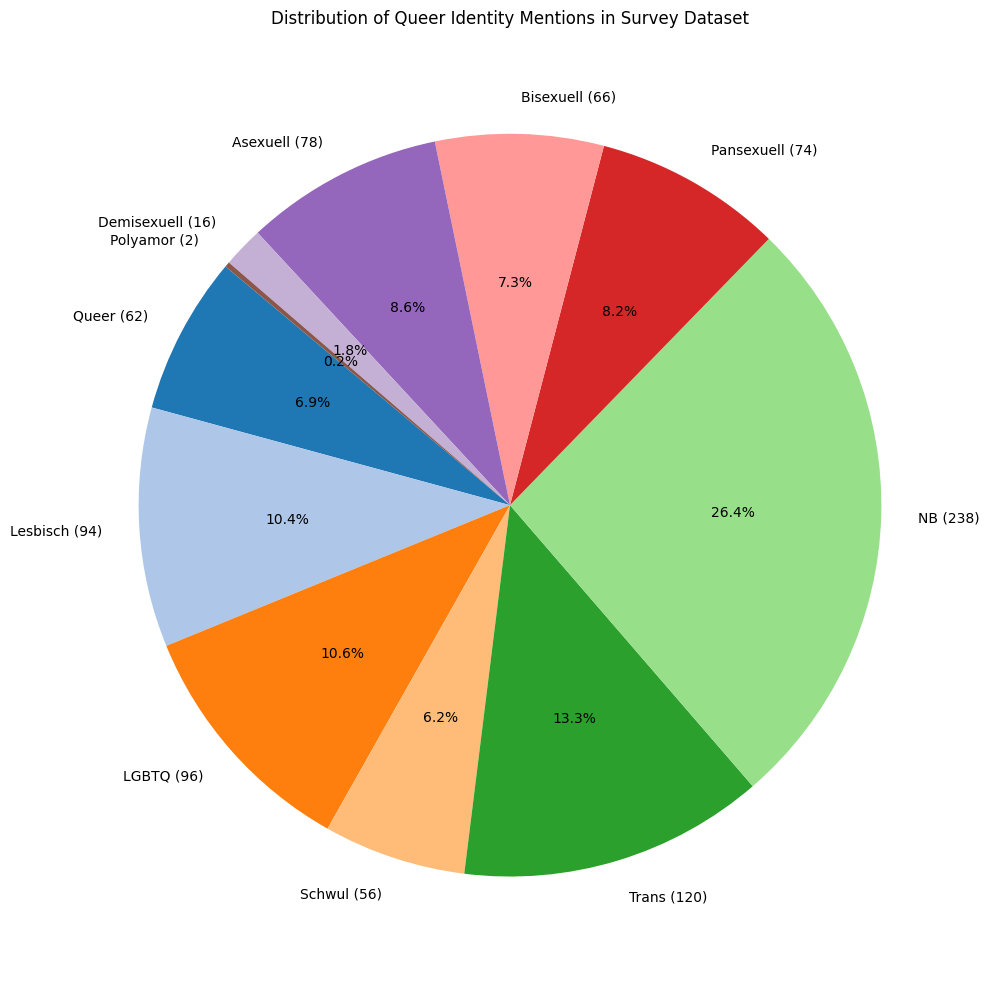

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Original summary lines (trimmed to relevant part)
summary_lines = """
Group: Queer, Cis Frau, Lesbisch, N: 2
Group: Queer, N: 49
Group: Cis Frau, N: 51
Group: Lesbisch, N: 65
Group: Lesbisch, Cis Frau, N: 19
Group: LGBTQ, N: 93
Group: LGBTQ, Schwul, N: 1
Group: Schwul, N: 41
Group: Trans, N: 62
Group: Nicht-binär, Lesbisch, N: 5
Group: Nicht-binär, N: 96
Group: Nicht-binär, Pansexuell, N: 14
Group: Pansexuell, N: 56
Group: Bisexuell, Cis Frau, N: 9
Group: Bisexuell, N: 50
Group: Asexuell, N: 51
Group: Asexuell, Cis Frau, N: 13
Group: Schwul, Cis Mann, N: 13
Group: Cis Mann, N: 27
Group: Queer, Cis Mann, N: 2
Group: Bisexuell, Cis Mann, N: 4
Group: Genderqueer, N: 41
Group: Agender, N: 19
Group: Trans Mann, N: 53
Group: Demisexuell, N: 13
Group: Queer, Cis Frau, N: 7
Group: Genderfluid, Genderqueer, N: 6
Group: Genderfluid, N: 17
Group: Asexuell, Cis Mann, N: 7
Group: Polyamor, Cis Frau, Queer, N: 1
Group: Polyamor, N: 1
Group: Trans Frau, N: 2
Group: LGBTQ, Trans, Genderqueer, N: 2
Group: Agender, Genderqueer, N: 3
Group: Genderfluid, Nicht-binär, N: 2
Group: Agender, Genderqueer, Genderfluid, N: 5
Group: Cis Mann, Asexuell, N: 1
Group: Demisexuell, Pansexuell, Asexuell, N: 3
Group: Lesbisch, Asexuell, N: 2
Group: Asexuell, Genderqueer, N: 1
Group: Bisexuell, Trans Mann, N: 1
Group: Nicht-binär, Queer, N: 1
Group: Lesbisch, Nicht-binär, N: 1
Group: Schwul, Nicht-binär, N: 1
Group: Nicht-binär, Agender, N: 1
Group: Pansexuell, Bisexuell, N: 1
Group: Nicht-binär, Bisexuell, N: 1
"""

# Umbrella categories
identity_map = {
    "Trans Mann": "Trans",
    "Trans Frau": "Trans",
    "Trans": "Trans",
    "Nicht-binär": "NB",
    "Genderqueer": "NB",
    "Genderfluid": "NB",
    "Agender": "NB",
    "Cis Mann": None,
    "Cis Frau": None,
    "Queer": "Queer",
    "LGBTQ": "LGBTQ",
    "Lesbisch": "Lesbisch",
    "Schwul": "Schwul",
    "Bisexuell": "Bisexuell",
    "Pansexuell": "Pansexuell",
    "Asexuell": "Asexuell",
    "Demisexuell": "Demisexuell",
    "Polyamor": "Polyamor"
}

# Parse and count
identity_counter = Counter()
for line in summary_lines.strip().split("\n"):
    group_part = line.split("Group:")[1].split(", N:")[0].strip()
    n = int(line.split("N:")[1])
    identities = [i.strip() for i in group_part.split(",")]

    for identity in identities:
        mapped = identity_map.get(identity)
        if mapped:  # skip if None (e.g. Cis Mann)
            identity_counter[mapped] += n

# Plot
labels = list(identity_counter.keys())
counts = list(identity_counter.values())

plt.figure(figsize=(10, 10))
colors = plt.get_cmap("tab20").colors[:len(labels)]
plt.pie(counts, labels=[f"{l} ({c})" for l, c in zip(labels, counts)], colors=colors, startangle=140, autopct='%1.1f%%')
plt.title("Distribution of Queer Identity Mentions in Survey Dataset")
plt.axis("equal")
plt.tight_layout()
plt.savefig("survey_identity_queer_only_pie.png", dpi=300)
plt.show()


In [1]:
pip install matplotlib seaborn pandas


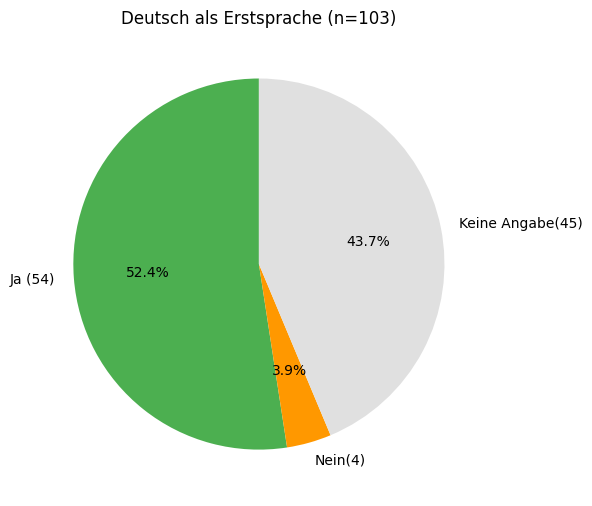

In [14]:
import matplotlib.pyplot as plt

labels = ['Ja (54)', 'Nein(4)', 'Keine Angabe(45)']
values = [54, 4, 45]

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#4caf50', '#ff9800', '#e0e0e0'])
plt.title('Deutsch als Erstsprache (n=103)')
plt.tight_layout()
plt.show()


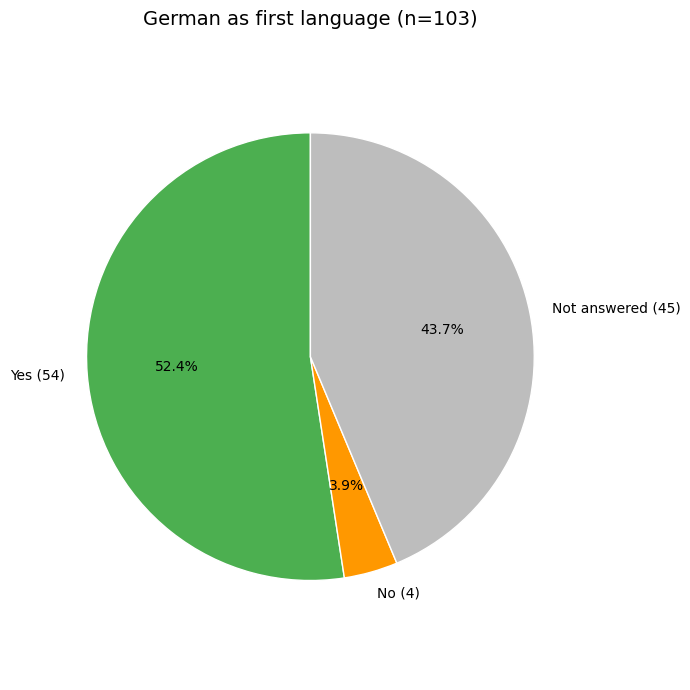

In [16]:
# prompt: import matplotlib.pyplot as plt
# labels = ['Ja (54)', 'Nein(4)', 'Keine Angabe(45)']
# values = [54, 4, 45]
# plt.figure(figsize=(6, 6))
# plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#4caf50', '#ff9800', '#e0e0e0'])
# plt.title('Deutsch als Erstsprache (n=103)')
# plt.tight_layout()
# plt.show() what is a nicer way to show this?

import matplotlib.pyplot as plt
# Data from the original example
labels = ['Yes (54)', 'No (4)', 'Not answered (45)'] # Corrected the labels to be consistent
values = [54, 4, 45]

# Colors for clarity
colors = ['#4CAF50', '#FF9800', '#BDBDBD'] # Green, Orange, Grey

plt.figure(figsize=(7, 7)) # Slightly larger figure
plt.pie(
    values,
    labels=labels,
    autopct='%1.1f%%', # Show percentages with one decimal place
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white'} # Add white edges to wedges
)
plt.title('German as first language (n=103)', fontsize=14) # Increase title font size
plt.axis('equal') # Ensure pie chart is a circle
plt.tight_layout() # Adjust layout to prevent labels overlapping

# Optionally save the plot
# plt.savefig('deutsch_erstsprache_pie.png', dpi=300)

plt.show()


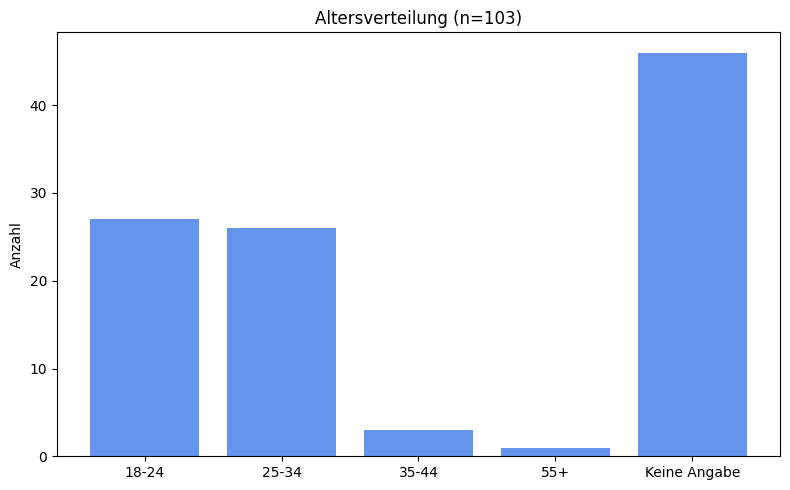

In [12]:
labels = ['18-24', '25-34', '35-44', '55+', 'Keine Angabe']
values = [27, 26, 3, 1, 46]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color='cornflowerblue')
plt.ylabel('Anzahl')
plt.title('Altersverteilung (n=103)')
plt.tight_layout()
plt.show()


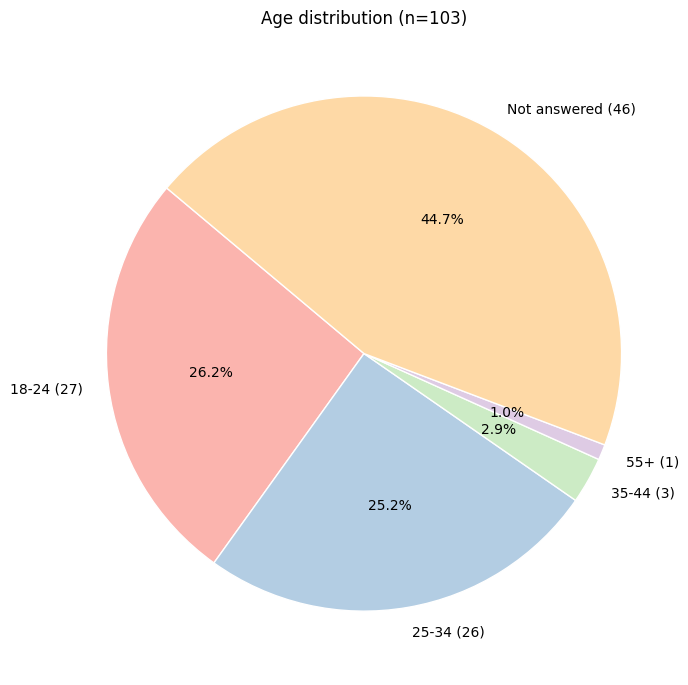

In [18]:
# prompt: labels = ['18-24', '25-34', '35-44', '55+', 'Keine Angabe']
# values = [27, 26, 3, 1, 46]
# plt.figure(figsize=(8, 5))
# plt.bar(labels, values, color='cornflowerblue')
# plt.ylabel('Anzahl')
# plt.title('Altersverteilung (n=103)')
# plt.tight_layout()
# plt.show()
#  turn to pie chart maybe?

import matplotlib.pyplot as plt
# Pie chart for Altersverteilung
labels = ['18-24 (27)', '25-34 (26)', '35-44 (3)', '55+ (1)', 'Not answered (46)']
values = [27, 26, 3, 1, 46]
colors = plt.get_cmap('Pastel1').colors # Using a different colormap for distinction

plt.figure(figsize=(7, 7)) # Adjust size for a pie chart
plt.pie(
    values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140, # Adjust start angle for better visual
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Age distribution (n=103)')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

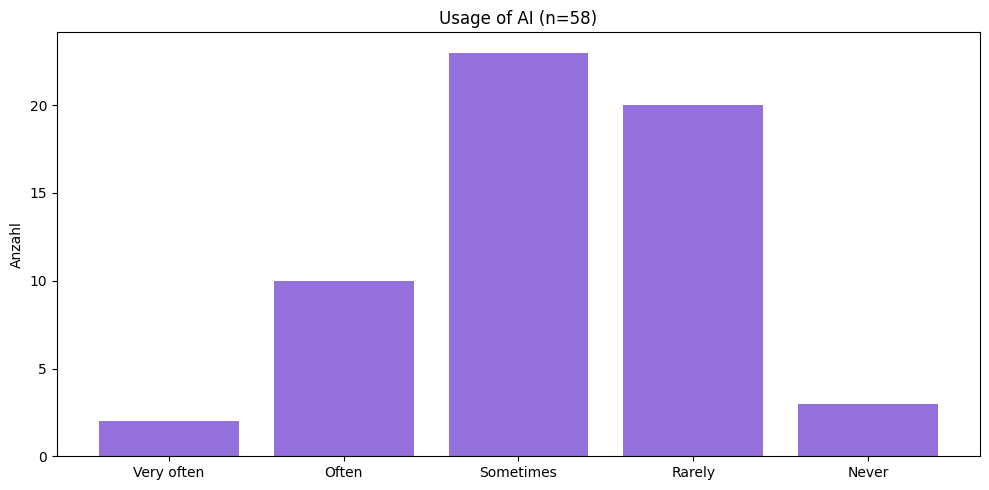

In [21]:
labels = ['Very often', 'Often', 'Sometimes', 'Rarely', 'Never']
values = [2, 10, 23, 20, 3]

plt.figure(figsize=(10, 5))
plt.bar(labels, values, color='mediumpurple')
plt.ylabel('Anzahl')
plt.title('Usage of AI (n=58)')
plt.tight_layout()
plt.show()


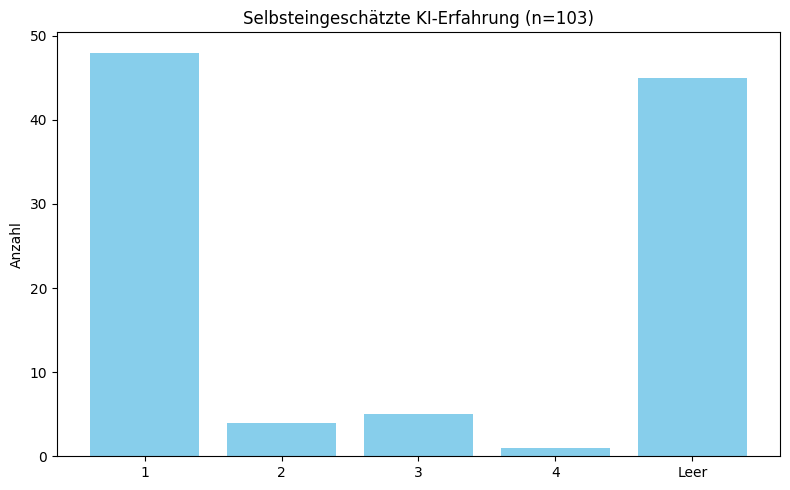

In [5]:
labels = ['1', '2', '3', '4', 'Keine Angabe']
values = [48, 4, 5, 1, 45]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color='skyblue')
plt.ylabel('Anzahl')
plt.title('Selbsteingeschätzte KI-Erfahrung (n=103)')
plt.tight_layout()
plt.show()


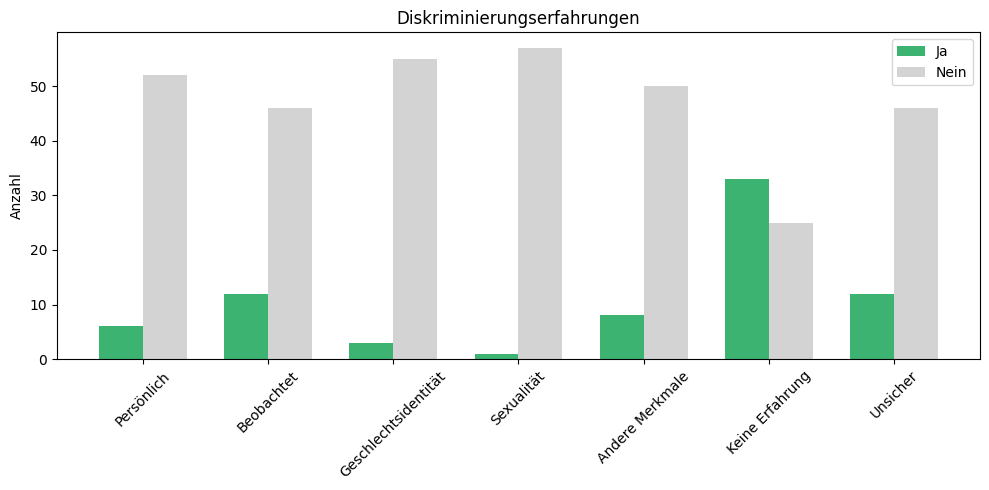

In [6]:
labels = ['Persönlich', 'Beobachtet', 'Geschlechtsidentität', 'Sexualität', 'Andere Merkmale', 'Keine Erfahrung', 'Unsicher']
yes =     [6, 12, 3, 1, 8, 33, 12]
no =      [52, 46, 55, 57, 50, 25, 46]

import numpy as np
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, yes, width, label='Ja', color='mediumseagreen')
bars2 = ax.bar(x + width/2, no, width, label='Nein', color='lightgray')

ax.set_ylabel('Anzahl')
ax.set_title('Diskriminierungserfahrungen')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


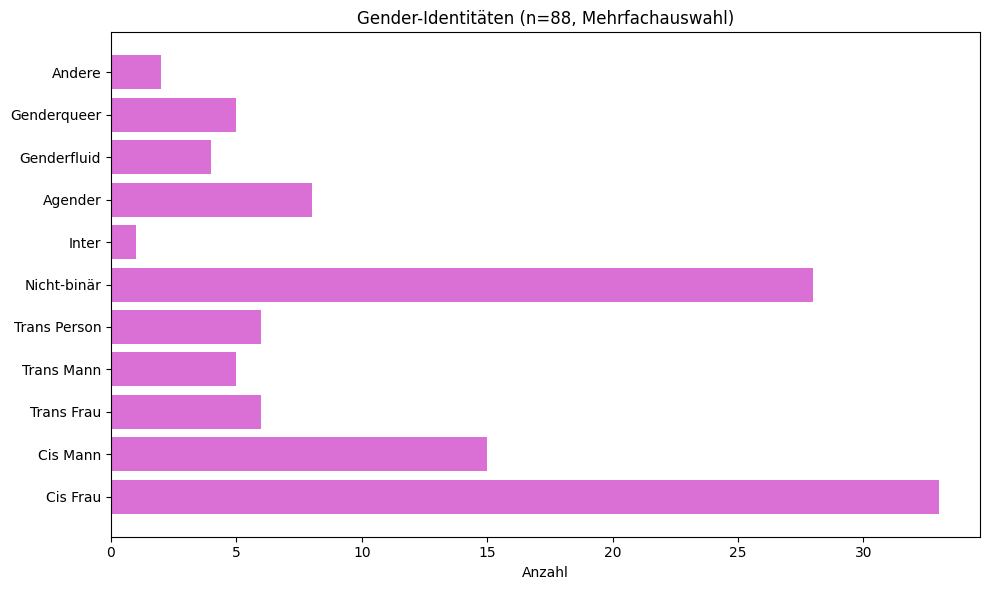

In [7]:
labels = ['Cis Frau', 'Cis Mann', 'Trans Frau', 'Trans Mann', 'Trans Person',
          'Nicht-binär', 'Inter', 'Agender', 'Genderfluid', 'Genderqueer', 'Andere']
values = [33, 15, 6, 5, 6, 28, 1, 8, 4, 5, 2]

plt.figure(figsize=(10, 6))
plt.barh(labels, values, color='orchid')
plt.xlabel('Anzahl')
plt.title('Gender-Identitäten (n=88, Mehrfachauswahl)')
plt.tight_layout()
plt.show()


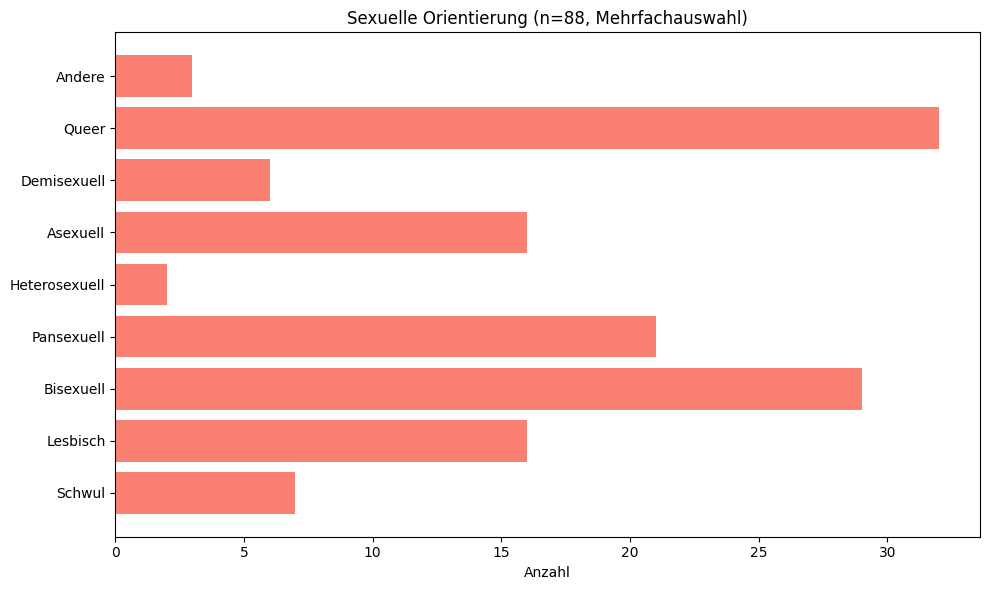

In [8]:
labels = ['Schwul', 'Lesbisch', 'Bisexuell', 'Pansexuell', 'Heterosexuell',
          'Asexuell', 'Demisexuell', 'Queer', 'Andere']
values = [7, 16, 29, 21, 2, 16, 6, 32, 3]

plt.figure(figsize=(10, 6))
plt.barh(labels, values, color='salmon')
plt.xlabel('Anzahl')
plt.title('Sexuelle Orientierung (n=88, Mehrfachauswahl)')
plt.tight_layout()
plt.show()


/tmp/ipython-input-9-640023339.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_labels, y=gender_counts, ax=axs[0], palette='cool')
/tmp/ipython-input-9-640023339.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sex_labels, y=sexuality_counts, ax=axs[1], palette='rocket')


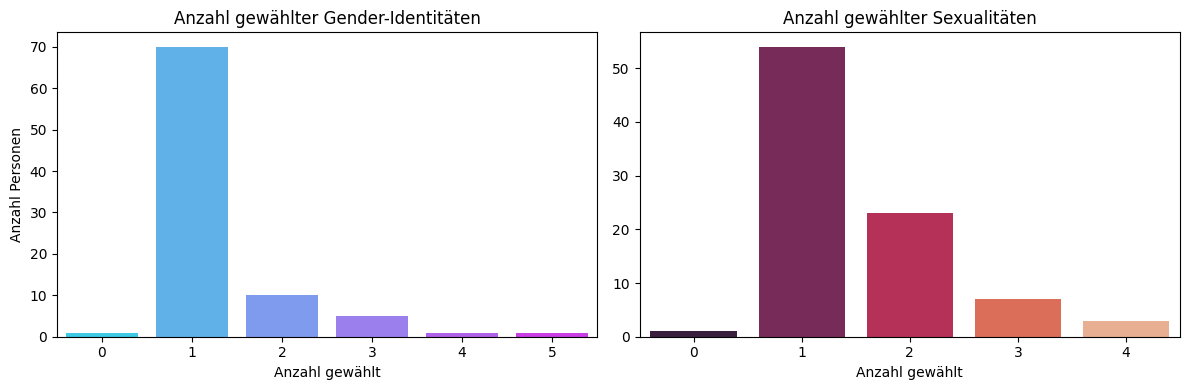

In [9]:
import seaborn as sns

# Gender: Anzahl Optionen ausgewählt
gender_counts = [1, 70, 10, 5, 1, 1]
sexuality_counts = [1, 54, 23, 7, 3]
gender_labels = ['0', '1', '2', '3', '4', '5']
sex_labels = ['0', '1', '2', '3', '4']

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=gender_labels, y=gender_counts, ax=axs[0], palette='cool')
axs[0].set_title('Anzahl gewählter Gender-Identitäten')
axs[0].set_xlabel('Anzahl gewählt')
axs[0].set_ylabel('Anzahl Personen')

sns.barplot(x=sex_labels, y=sexuality_counts, ax=axs[1], palette='rocket')
axs[1].set_title('Anzahl gewählter Sexualitäten')
axs[1].set_xlabel('Anzahl gewählt')

plt.tight_layout()
plt.show()


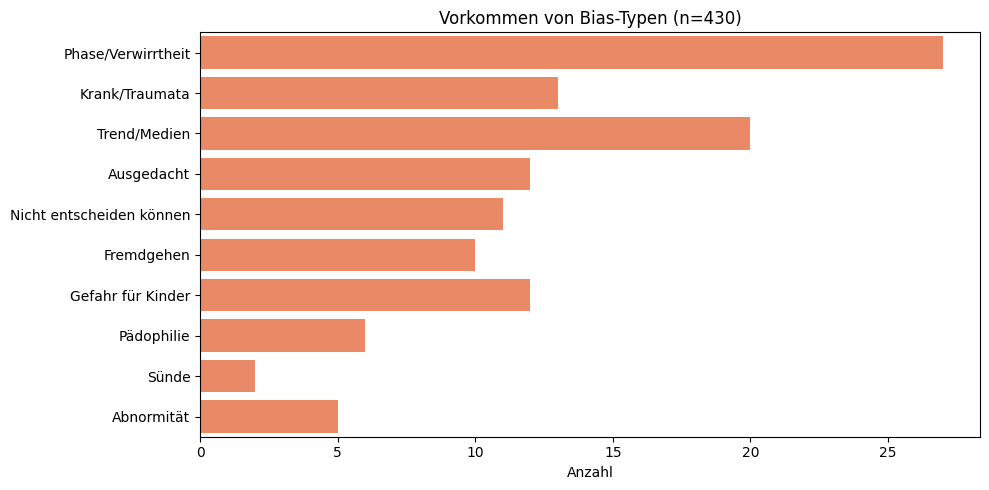

In [10]:
bias_types = {
    'Phase/Verwirrtheit': 27,
    'Krank/Traumata': 13,
    'Trend/Medien': 20,
    'Ausgedacht': 12,
    'Nicht entscheiden können': 11,
    'Fremdgehen': 10,
    'Gefahr für Kinder': 12,
    'Pädophilie': 6,
    'Sünde': 2,
    'Abnormität': 5
}

labels = list(bias_types.keys())
values = list(bias_types.values())

plt.figure(figsize=(10, 5))
sns.barplot(x=values, y=labels, color='coral')
plt.xlabel('Anzahl')
plt.title('Vorkommen von Bias-Typen (n=430)')
plt.tight_layout()
plt.show()
